In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Define the custom dataset class
class AptosDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.data.iloc[idx, 0] + ".png")
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [8]:
# Define transformations for ResNet-50
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# Set paths (Update these paths according to your dataset location)
image_dir = "train_images"  # Folder containing APTOS images
csv_file = "train.csv"     # CSV file with image names

In [12]:
# Load dataset and DataLoader
dataset = AptosDataset(image_dir, csv_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)  # Set num_workers=0


In [14]:
# Load pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])  # Remove last FC layer
resnet50 = resnet50.to(device)
resnet50.eval()  # Set model to evaluation mode

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [16]:
# Extract features
features_list = []

with torch.no_grad():  # No need to calculate gradients
    for images in dataloader:
        images = images.to(device)
        features = resnet50(images)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten features
        features_list.append(features.cpu().numpy())  # Move to CPU before converting to NumPy

# Convert list to numpy array
features_array = np.vstack(features_list)
print("Extracted features shape:", features_array.shape)

# Save extracted features
np.save("aptos_resnet50_features.npy", features_array)

print("Feature extraction completed and saved as 'aptos_resnet50_features.npy'")

Extracted features shape: (3662, 2048)
Feature extraction completed and saved as 'aptos_resnet50_features.npy'


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load extracted ResNet-50 features
features_array = np.load("aptos_resnet50_features.npy")
print("Original feature shape:", features_array.shape)

Original feature shape: (3662, 2048)


In [20]:
n_components = 100  # Reduce to 100 dimensions (You can adjust this)
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(features_array)

print("Reduced feature shape:", reduced_features.shape)

Reduced feature shape: (3662, 100)


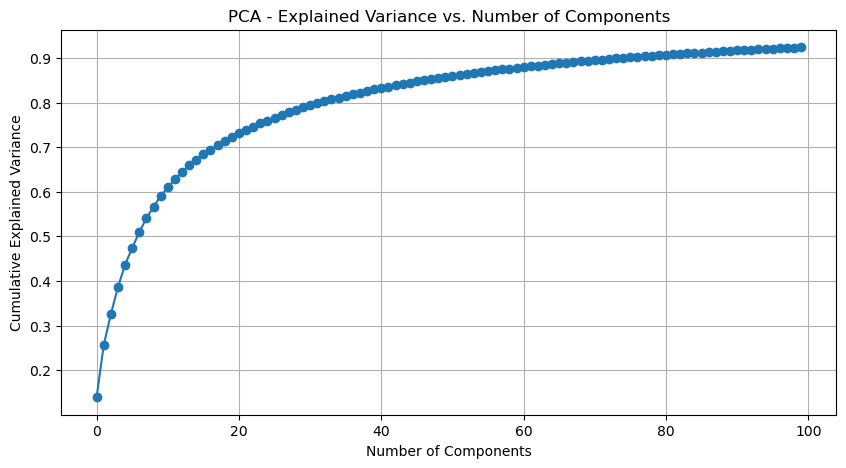

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid()
plt.show()

In [24]:
np.save("aptos_pca_features.npy", reduced_features)
print("PCA features saved as 'aptos_pca_features.npy'.")

PCA features saved as 'aptos_pca_features.npy'.


In [4]:
import pandas as pd
import numpy as np

# Load the dataset CSV (update the filename if needed)
df = pd.read_csv("train.csv")  # Ensure this file exists in your directory

# Display first few rows
print(df.head())



        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [6]:
# Extract labels (convert to numpy array)
labels = df["diagnosis"].values

# Save labels for future use
np.save("labels.npy", labels)

# Confirm labels are saved correctly
print("Labels saved successfully! Shape:", labels.shape)

Labels saved successfully! Shape: (3662,)


In [31]:
# Load and print labels
labels = np.load("labels.npy")
print("Loaded Labels Shape:", labels.shape)
print("Unique Classes in Labels:", np.unique(labels))

Loaded Labels Shape: (3662,)
Unique Classes in Labels: [0 1 2 3 4]


In [2]:

import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Load PCA Features and Labels
X = np.load("aptos_pca_features.npy")  # PCA-reduced features
y = np.load("aptos_labels.npy")  # Corresponding class labels

print("Original class distribution:", Counter(y))

# Step 2: Apply SMOTE for Balancing Classes
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Balanced class distribution:", Counter(y_resampled))

# Step 3: Save the Balanced Dataset
np.save("aptos_smote_features.npy", X_resampled)
np.save("aptos_smote_labels.npy", y_resampled)

print("SMOTE-applied features saved as 'aptos_smote_features.npy'")
print("SMOTE-applied labels saved as 'aptos_smote_labels.npy'")


Original class distribution: Counter({0: 1805, 2: 999, 1: 370, 4: 295, 3: 193})
Balanced class distribution: Counter({2: 1805, 4: 1805, 1: 1805, 0: 1805, 3: 1805})
SMOTE-applied features saved as 'aptos_smote_features.npy'
SMOTE-applied labels saved as 'aptos_smote_labels.npy'


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Load Balanced Dataset (After SMOTE)
X = np.load("aptos_smote_features.npy")  # Balanced features
y = np.load("aptos_smote_labels.npy")    # Balanced labels

# Step 2: Split into Train (70%) & Test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Step 3: Save the Split Datasets
np.save("aptos_X_train.npy", X_train)
np.save("aptos_X_test.npy", X_test)
np.save("aptos_y_train.npy", y_train)
np.save("aptos_y_test.npy", y_test)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Train-Test Split Completed ✅")


Training set shape: (6317, 100) (6317,)
Testing set shape: (2708, 100) (2708,)
Train-Test Split Completed ✅


In [11]:
import numpy as np
import time  # Import time module
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

# Step 1: Load Train-Test Data
X_train = np.load("aptos_X_train.npy")
y_train = np.load("aptos_y_train.npy")
X_test = np.load("aptos_X_test.npy")
y_test = np.load("aptos_y_test.npy")

In [13]:

# Step 2: Normalize Features (Important for SVM!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Step 3: Define the SVM Model
svm = SVC()

# Step 4: Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2]  # Limit polynomial kernel to degree 2 (for speed)
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    svm, param_grid, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=3, random_state=42
)

print("Starting Randomized Search...")
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

print(f"Randomized Search completed in {end_time - start_time:.2f} seconds")
print("Best Hyperparameters:", random_search.best_params_)

best_svm = random_search.best_estimator_



Starting Randomized Search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END C=10, degree=2, gamma=auto, kernel=rbf;, score=0.958 total time=   8.4s
[CV 1/3] END C=1, degree=2, gamma=auto, kernel=linear;, score=0.764 total time=   9.0s
[CV 3/3] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.733 total time=   8.5s
[CV 2/3] END C=0.1, degree=2, gamma=auto, kernel=poly;, score=0.635 total time=   4.2s
[CV 1/3] END C=10, degree=2, gamma=auto, kernel=rbf;, score=0.955 total time=   8.4s
[CV 3/3] END C=1, degree=2, gamma=auto, kernel=poly;, score=0.919 total time=   3.1s
[CV 2/3] END C=10, degree=2, gamma=scale, kernel=rbf;, score=0.958 total time=   5.8s
[CV 2/3] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.758 total time=   8.6s
[CV 1/3] END C=0.1, degree=2, gamma=auto, kernel=poly;, score=0.654 total time=   4.2s
[CV 3/3] END C=0.1, degree=2, gamma=auto, kernel=poly;, score=0.644 total time=   4.0s
[CV 3/3] END C=1, degree=2, gamma=scale, kerne